### 0. Intro
In this exercise, we are going to use Alexnet which is one of the most basic CNNs to classify if subject has pneumonia. It is not designed to achieve 100% accuracy model but to introduce how to train a CNN model using pytorch. People can apply different methods or networks based on this very basic model.
After completing this, you can try several things to increase accuracy:
- Use different networks, such as VGG, ResNet, or Inception
- Or create your own network
- Change some hyperparameters, such as learning rate
- Instead of removing data to match imbalance of classes, you could use class imbalacne ratio to update weights. [(Ref.) ](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#1.-Introduction-+-Set-up)
    

In [1]:
import torch
import torchvision
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import random
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nan
from torch.autograd import Variable

import time


In [2]:
root_path = '../input/chest-xray-pneumonia/chest_xray/chest_xray'
train_path = os.path.join(root_path,'train')
test_path = os.path.join(root_path,'test')
category = ['NORMAL', 'PNEUMONIA']
img_size = 224
# AlexNet uses 224x224x3

### 1. Data Loading

In [3]:
def load_data_dir(data_path, img_size,labels):
    # load data from the data_path
    data = [] 
    for label in labels: 
        dir_path = os.path.join(data_path, label)
        binary_label = labels.index(label)
        for img_path in os.listdir(dir_path):
            if img_path[-5:]=='.jpeg':
                img = cv2.imread(os.path.join(dir_path, img_path), cv2.IMREAD_GRAYSCALE)
                # Resize img by img_size x img_size
                resized_img = cv2.resize(img, (img_size, img_size))
                data.append([resized_img, binary_label])   

    return np.array(data, dtype=object)

In [4]:
train_df = load_data_dir(train_path, img_size, category)
test_df = load_data_dir(test_path, img_size, category)
print("# of train data: " + str(len(train_df)))
print("# of test data: " + str(len(test_df)))

# of train data: 5216
# of test data: 624


### 2. EDA
Let's visualize some images.

In [5]:
def subplot_square(data, label, size):
    # [size x size] subplot figure
    
    fig, ax = plt.subplots(size,size,figsize = (9, 9))
    ran_i = random.sample(range(0,len(data)-1),size*size)
    for i in range(size):
        for j in range(size):
            ax[i,j].imshow(data[ran_i[i*size+j]],cmap='gray')
            ax[i,j].set_title(label[ran_i[i*size+j]]) 
            ax[i,j].set_axis_off()  

Binary label is used:
- 0: Normal subject
- 1: Pneumonia subject

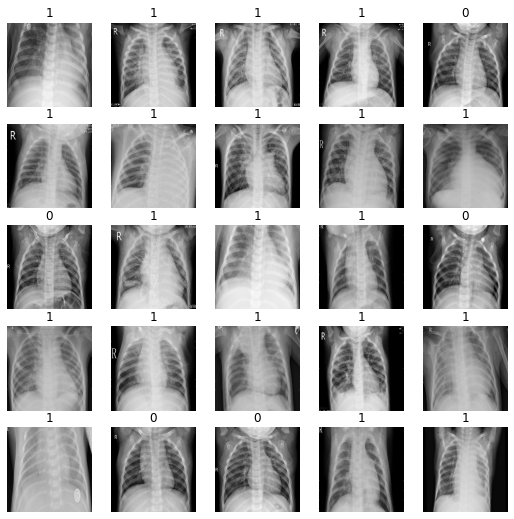

In [6]:
subplot_square(train_df[:,0], train_df[:,1], size=5)

Check # of each class

Text(0.5, 1.0, 'Test')

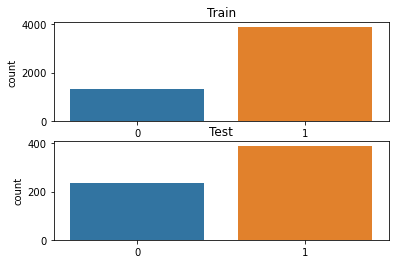

In [7]:
fig, axes = plt.subplots(2,1)
sns.countplot(x=train_df[:,1], ax=axes[0])
axes[0].set_title('Train') 
sns.countplot(x=test_df[:,1], ax=axes[1])
axes[1].set_title('Test') 

Match class imbalance by removing some pneumonia cases such taht:
- number of pneumonia subjects = number of normal subjects

Text(0.5, 1.0, 'Test')

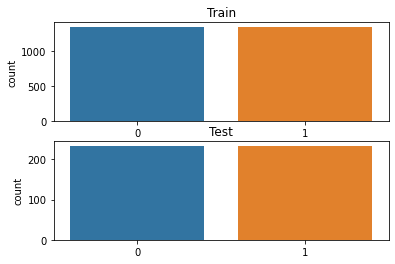

In [8]:
N_i = np.argwhere(train_df[:,1]==0).ravel().tolist()
P_i = np.argwhere(train_df[:,1]==1).ravel().tolist()
sampled_P_i = sample(P_i,len(N_i))
train_df = train_df[sampled_P_i+N_i, :]

N_i = np.argwhere(test_df[:,1]==0).ravel().tolist()
P_i = np.argwhere(test_df[:,1]==1).ravel().tolist()
sampled_P_i = sample(P_i,len(N_i))
test_df = test_df[sampled_P_i+N_i, :]

fig, axes = plt.subplots(2,1)
sns.countplot(x=train_df[:,1], ax=axes[0])
axes[0].set_title('Train') 
sns.countplot(x=test_df[:,1], ax=axes[1])
axes[1].set_title('Test') 

### 3. Data Preprocessing:
- split data to x & y
- Normalize images
- convert to float32 tensor
- Build DataLoaders for train and test dataset

In [9]:
def Build_Dataloader(df, BATCH_SIZE):
    # Input: df
    #    - df[:,0]: img
    #    - df[:,1]: label
    # Output: Dataloader
    
    x, y = [], []
    for img,label in df:
        x.append(img)
        y.append(label)
    
    # Normalize pixel values from [0,255] to [0,1] 
    x = np.array(x)/255
    y = np.array(y)
    dataset = TensorDataset(torch.from_numpy(x.astype(np.float32)),
                            torch.from_numpy(y))
    data_loader = DataLoader(dataset,
                             batch_size=BATCH_SIZE,
                             shuffle = True,
                             drop_last=True)
    return data_loader

In [10]:
BATCH_SIZE = 64
train_loader = Build_Dataloader(train_df, BATCH_SIZE = BATCH_SIZE)
test_loader = Build_Dataloader(test_df, BATCH_SIZE = BATCH_SIZE)

### 4. Build the AlexNet Model

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11,stride=4,padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96,256,5,padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256,384,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(384,384,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(384,256,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2), # (b x 256 x 6 x 6)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
        self.init_bias()
        
    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias,0)
        nn.init.constant_(self.net[4].bias,1)
        nn.init.constant_(self.net[10].bias,1)
        nn.init.constant_(self.net[12].bias,1)
        
    def forward(self,x):
        x = self.net(x)
        x = x.view(-1,256 * 6 * 6)
        x = self.classifier(x)
        return x

In [12]:
# Use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = AlexNet().to(device)

cuda


In [13]:
error = nn.CrossEntropyLoss()
learning_rate = 0.0001

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. Start Training

In [14]:
count = 0
num_epochs = 50
loss_list = []
epoch_list = []
accuracy_list = []
precision_list = []
accuracy_list = []
recall_list = []

start = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(BATCH_SIZE,1,224,224)).to(device)
        labels = Variable(labels).to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()

    # Calculate Accuracy for each epoch   
    correct = 0
    total = 0
    tp,fp,fn,tn = 0,0,0,0
    # Iterate through test dataset
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        test = Variable(images.view(BATCH_SIZE,1,224,224)).to(device)
        # Forward propagation
        outputs = model(test)
        
        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1]
        predicted_ = predicted.cpu().detach().numpy()
        labels_ = labels.cpu().detach().numpy()
        cm = confusion_matrix(labels_, predicted_)
        tn_, fp_, fn_, tp_ = cm.ravel()

        tn += tn_
        fp += fp_
        fn += fn_
        tp += tp_
        total += len(labels)
        correct += (predicted == labels).sum()

    accuracy = 100*correct/float(total)
    accuracy_list.append(accuracy)
    
    if tp==0:
        # Avoid 0/0 cases
        precision=0
        recall=0
    else:
        precision = 100*tp/float(tp+fp)
        recall = 100*tp/float(tp+fn)
    precision_list.append(precision)
    recall_list.append(recall)
    loss_list.append(loss.data)
    epoch_list.append(epoch)
    

    # Print Loss
    if epoch%5==0:
        print('Epoch: {}  Loss: {}  Accuracy: {} %'.format(epoch, loss.data, accuracy))

end = time.time()
print('Elaspsed time: ' + str(end - start))

Epoch: 0  Loss: 0.6960006356239319  Accuracy: 50.000003814697266 %
Epoch: 5  Loss: 0.6935231685638428  Accuracy: 45.312503814697266 %
Epoch: 10  Loss: 0.28212645649909973  Accuracy: 78.34822082519531 %
Epoch: 15  Loss: 0.21140927076339722  Accuracy: 75.89286041259766 %
Epoch: 20  Loss: 0.18566222488880157  Accuracy: 72.3214340209961 %
Epoch: 25  Loss: 0.11533268541097641  Accuracy: 76.33928680419922 %
Epoch: 30  Loss: 0.04917488619685173  Accuracy: 72.99107360839844 %
Epoch: 35  Loss: 0.1283564418554306  Accuracy: 74.55357360839844 %
Epoch: 40  Loss: 0.038030002266168594  Accuracy: 74.10714721679688 %
Epoch: 45  Loss: 0.023530982434749603  Accuracy: 76.5625 %
Elaspsed time: 153.75555396080017


### 6. Results

Text(0.5, 0, 'Epoch')

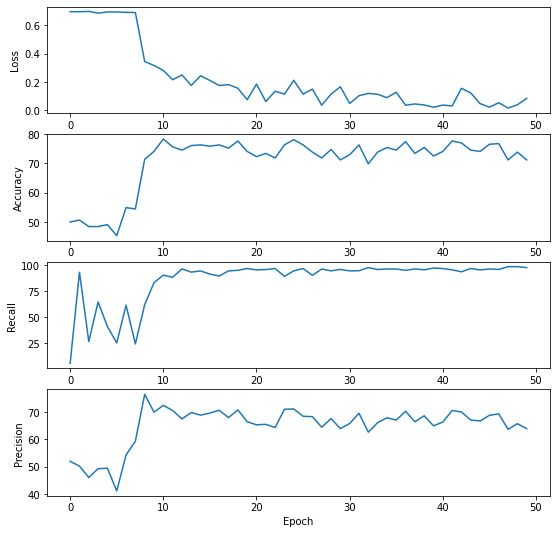

In [15]:
fig, axes = plt.subplots(4,1,figsize=(9,9))
axes[0].plot(epoch_list,loss_list)
axes[0].set_ylabel("Loss")
axes[1].plot(epoch_list,accuracy_list)
axes[1].set_ylabel("Accuracy")
axes[2].plot(epoch_list,recall_list)
axes[2].set_ylabel("Recall")
axes[3].plot(epoch_list,precision_list)
axes[3].set_ylabel("Precision")
axes[3].set_xlabel("Epoch")

Save parameters for inference

In [16]:
torch.save(model.state_dict(), './model1.pth')

### 7. Inference

Load previously saved parameters

In [17]:
inf_model = AlexNet()
inf_model.to(torch.device('cuda'))
inf_model.load_state_dict(torch.load('./model1.pth'))
inf_model.eval()

AlexNet(
  (net): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=Tr

Check val directory

In [18]:
val_path = os.path.join(root_path,'val')
val_df = load_data_dir(val_path, img_size, category)
print("# of test data: " + str(len(val_df)))

# of test data: 16


In [19]:
x_val, y_val = [], []
for img,label in val_df:
    x_val.append(img)
    y_val.append(label)

# Normalize pixel values from [0,255] to [0,1] 
x_val = np.array(x_val)/255
y_val = np.array(y_val)
img = torch.from_numpy(x_val.astype(np.float32))

In [20]:
pred = []
for i in range(len(val_df)):
    val = Variable(img[i].view(1,1,224,224)).to(device)
    outputs = inf_model(val)
    predicted = torch.max(outputs.data,1)[1]
    pred.append(predicted.item())

[[8 0]
 [0 8]]
Accuracy: 100.0
Precision: 100.0
Recall: 100.0


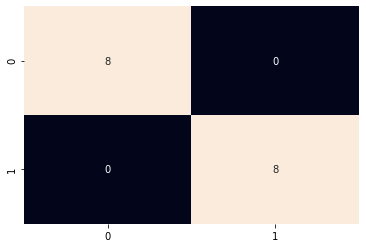

In [21]:
cm = confusion_matrix(y_val, pred)
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(cm)
print('Accuracy: ' + str(sum(pred==y_val)/len(y_val)*100))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
sns.heatmap(cm,annot=True,cbar=False)

Visualize results

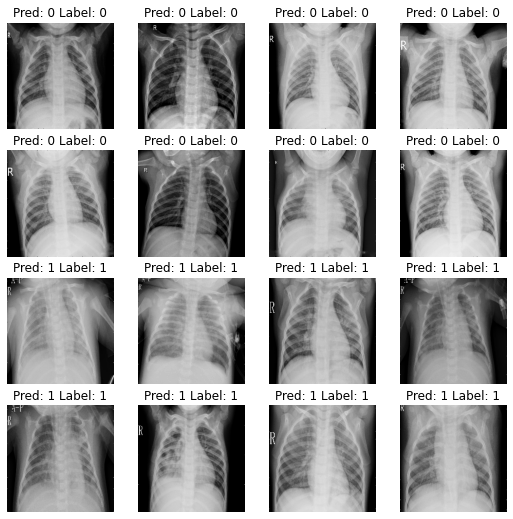

In [22]:
fig, ax = plt.subplots(4,4, figsize=(9,9))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(x_val[i*4+j],cmap='gray')
        ax[i,j].set_title('Pred: ' + str(pred[i*4+j]) 
                          + " Label: "+str(y_val[i*4+j]))
        ax[i,j].set_axis_off()

Although 100% accuracy is achieved for validation, only 16 data were used. 